In [1]:
import random
import math
import matplotlib.pyplot as plt
from pytsp import atsp_tsp, run, dumps_matrix

In [2]:
class Point:
    """A class to manage our points.
    Not especially computationally efficient, but needn't be.
    """

    
    def __init__(self, x=None, y=None):
        if x != None:
            self.x = x
            self.y = y
        else:
            self.x = random.random()
            self.y = random.random()
            self.index = None
            
        self.master_id = -1
        self.id = -1
        self.c2lp((0.5,0.5))

    def c2p(self, origin):
        """Cartesian to polar.
        given tuple origin, calculate polar coordinates of point"""
        relative_x = self.x - origin[0]
        relative_y = self.y - origin[1]
        self.r = math.sqrt(relative_x**2 + relative_y**2)
        self.theta = math.atan2(relative_y,relative_x)
        
    def c2lp(self, origin):
        """Cartesian to log-polar.
        given tuple origin, calculate log-polar coordinates of point"""
        relative_x = self.x - origin[0]
        relative_y = self.y - origin[1]
        self.r = math.log1p(self.distance(relative_x, relative_y))
        self.theta = math.atan2(relative_y,relative_x)
        
    def get_dist(self,target):
        distance = self.distance((self.y - target.y),(self.x - target.x))
        

        return distance
        
    def get_lp_dist2(self,target):
        distance = min(self.distance((self.theta - target.theta),(self.r - target.r)),
                       self.distance((2*math.pi-(self.theta - target.theta)),(self.r - target.r)))
        return distance
    
    def get_lp_dist(self,target):
        distance1 = self.distance((self.theta - target.theta),(self.r - target.r))
        distance2 = self.distance((2*math.pi-abs(self.theta - target.theta)),(self.r - target.r))
        return min(distance1, distance2)
        
    def distance(self,x,y):
        return math.sqrt(x**2+y**2)

In [3]:
class TSP:
    
    SCALE = 1000
    DISCOUNT = -20000
    
    def __init__(self, npoints):

        self.size = npoints
        self.origin = (0.5,0.5)

        self.csolution = None
        self.psolution = None
        self.clength = None
        self.plength = None
        self.start = 0
        self.built_path = []
        self.generate(npoints)
        self.set_origin(self.origin)
        
    def generate(self, npoints):
        self.master_points = [Point() for _ in range(npoints)]
        self.point_dict = {}
        for index, point in enumerate(self.master_points):
            point.master_id = point.id = index
            self.point_dict[index] = point
        self.points = self.master_points
        
    def csolve(self):
        matrix = self.generate_dist_matrix()
        self.csolution, self.clength = self.generate_concorde_tour(matrix)
        
    def psolve(self, origin):
        self.set_origin(origin)
        matrix = self.generate_lp_dist_matrix()
        self.psolution, self.plength = self.generate_concorde_tour(matrix)
        
    def mpsolve(self, origin, start, end):
        start = self.point_dict[start].id
        end = self.point_dict[end].id
        
        self.set_origin(origin)
        matrix = self.generate_lp_dist_matrix()
        matrix[max(start,end)][min(start,end)] = TSP.DISCOUNT
        self.psolution, self.plength = self.generate_concorde_tour(matrix)
        
        self.psolution = [self.sub_dict[point].master_id for point in self.psolution]
        if self.psolution[1] == 0:
            self.psolution.reverse()
            while self.psolution[0] != self.sub_dict[self.start].master_id:
                self.psolution = [self.psolution[-1]] + self.psolution[0:-1]
        
    def msolve(self, start, end):
        substart = self.point_dict[start].id
        subend = self.point_dict[end].id
        
        matrix = self.generate_dist_matrix()
        matrix[max(substart,subend)][min(substart,subend)] = TSP.DISCOUNT
        self.csolution, self.plength = self.generate_concorde_tour(matrix)
        
        self.csolution = [self.sub_dict[point].master_id for point in self.csolution]
        if self.csolution[1] == 0:
            self.csolution.reverse()
            while self.csolution[0] != self.sub_dict[self.start].master_id:
                self.csolution = [self.csolution[-1]] + self.csolution[0:-1]
            
        
    def set_origin(self, origin):
        self.origin=origin
        for point in self.points:
            point.c2lp(origin)
    
    def generate_concorde_tour(self, matrix):
        matrix_sym = atsp_tsp(matrix, strategy="cutoff")
        outf = "/home/isaiah/projects/tsp/myroute_concorde2.tsp"
        with open(outf, 'w') as dest:
            dest.write(dumps_matrix(matrix_sym, name="My Route"))
        tourdata = run(outf, start=self.start, solver="concorde") #returns solution, metadata, tour length
        return tourdata['tour'], tourdata['solution']
    
    def generate_dist_matrix(self):

        self.distance_matrix = []
       # print(f"points is {len(self.points)} long")
        for point in  self.points:
            self.distance_matrix.append([point.get_dist(target)*TSP.SCALE for target in  self.points])
        return self.distance_matrix

    def generate_lp_dist_matrix(self):

        distance_matrix = []
        for point in  self.points:
            distance_matrix.append([point.get_lp_dist(target)*TSP.SCALE for target in self.points])
        return distance_matrix
    
    def display_c(self):
        plt.scatter([point.x for point in self.points],[point.y for point in self.points])
        
    def display_p(self):
        plt.scatter([point.theta for point in self.points],[point.r for point in self.points])
        
    
    def display_csolution(self):
        if not self.csolution:
            self.csolve()
        pointsorter = [point for point in self.points]
        sortdict = {self.csolution[i]:i for i in range(len(self.csolution))}
        pointsorter.sort(key=lambda point : sortdict[point.id])
    
        plt.plot([pointsorter[i].x for i in range(len(self.csolution))]+[pointsorter[0].x],[pointsorter[i].y for i in range(len(self.csolution))]+[pointsorter[0].y])
        plt.title('csolution')
        
    def display_psolution(self):
        #plot polar solution in polar coords
        if not self.psolution:
            self.origin = (0.5,0.5)
            self.psolve(self.origin)
        pointsorter = [point for point in self.points]
        sortdict = {self.psolution[i]:i for i in range(len(self.psolution))}
        pointsorter.sort(key=lambda point : sortdict[point.id])
    
        
        plt.plot([pointsorter[i].theta for i in range(len(self.psolution))]+[pointsorter[0].theta],[pointsorter[i].r for i in range(len(self.psolution))]+[pointsorter[0].r])
        #plt.scatter([self.points[tp1].theta], self.points[tp1].r)
        
    def display_cpsolution(self):
        #plot polar solution in cartesian coords
        if not self.psolution:
            self.origin = (0.5,0.5)
            self.psolve(self.origin)
        pointsorter = [point for point in self.points]
        sortdict = {self.psolution[i]:i for i in range(len(self.psolution))}
        pointsorter.sort(key=lambda point : sortdict[point.id])
    
        plt.plot([pointsorter[i].x for i in range(len(self.psolution))]+[pointsorter[0].x],[pointsorter[i].y for i in range(len(self.psolution))]+[pointsorter[0].y])
        plt.title(f"cpsolution, origin = {self.origin}")
        #plt.scatter([pointlist[tp1].theta], pointlist[tp1].r)
        
    def generate_subgraph(self, nodes):
        self.subgraph = [point for point in self.master_points if point.master_id in nodes]
        self.use_subgraph(True)


        
    def use_subgraph(self, toggle):
        if toggle == True:
            self.points = self.subgraph
            self.sub_dict = {}
            for index, point in enumerate(self.subgraph):
                point.id = index
                self.sub_dict[index] = point
            #self.points.sort(key=lambda x : x.master_id)

        else:
            self.points = self.master_points
            for index, point in enumerate(self.master_points):
                point.id = point.master_id
                
    def progressive_solution(self, stepsize):
        #this might be best as a generator.

        stepsize = min(stepsize, len(self.point_dict) - len(self.built_path))

        if len(self.built_path) == 0:
            self.csolve() #will need multi origins
            new_points = [self.point_dict[index].master_id for index in self.csolution[:stepsize]]

            self.built_path.extend(new_points)

            #make subgraph w/o 1 ... n-1
            self.generate_subgraph([point.master_id for point in self.master_points if point.master_id not in self.built_path[1:-1]])

        else:
        #make messenger matrix, solve
        #we need the subgraph id, but built_path uses master_ids
        #so we get point, then get point subgraph id
            if len(self.built_path) >= self.size:
                return
            self.use_subgraph(True)
            self.start = self.point_dict[self.built_path[-1]].id
            self.msolve(self.point_dict[self.built_path[0]].master_id,self.point_dict[self.built_path[-1]].master_id)
           # print(f'subsolution: {self.csolution}')
            
            if len(self.built_path) > self.size - 2:
                new_points = [self.point_dict[index].master_id for index in self.csolution]
            
            else:
                new_points = [self.point_dict[index].master_id for index in self.csolution[1:stepsize]]
        
            self.built_path.extend(new_points)

            #make subgraph w/o 1 ... n-1
            self.generate_subgraph([point.master_id for point in self.master_points if point.master_id not in self.built_path[1:-1]])

    def progressive_polar_solution(self, stepsize):
        #this might be best as a generator.

        stepsize = min(stepsize, len(self.point_dict) - len(self.built_path))

        if len(self.built_path) == 0:
            self.psolve(self.origin) #will need multi origins
            new_points = [self.point_dict[index].master_id for index in self.psolution[:stepsize]]

            self.built_path.extend(new_points)

            #make subgraph w/o 1 ... n-1
            self.generate_subgraph([point.master_id for point in self.master_points if point.master_id not in self.built_path[1:-1]])

        else:
        #make messenger matrix, solve
        #we need the subgraph id, but built_path uses master_ids
        #so we get point, then get point subgraph id
            if len(self.built_path) >= self.size:
                return
            self.use_subgraph(True)
            self.start = self.point_dict[self.built_path[-1]].id
            self.mpsolve(self.origin, self.point_dict[self.built_path[0]].master_id,self.point_dict[self.built_path[-1]].master_id)
           # print(f'subsolution: {self.csolution}')
            
            if len(self.built_path) > self.size - 2:
                new_points = [self.point_dict[index].master_id for index in self.psolution]
            
            else:
                new_points = [self.point_dict[index].master_id for index in self.psolution[1:stepsize]]
        
            self.built_path.extend(new_points)

            #make subgraph w/o 1 ... n-1
            self.generate_subgraph([point.master_id for point in self.master_points if point.master_id not in self.built_path[1:-1]])

    def calculate_path_length(self, path):
        total_length = 0
        for index, item in enumerate(path[:-1]):
            total_length += self.point_dict[path[index]].get_dist(self.point_dict[path[index+1]])
        total_length += self.point_dict[path[-1]].get_dist(self.point_dict[path[0]])
        return total_length


Using the above classes, we can do the following:
Generate and display a TSP

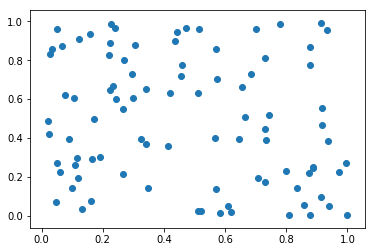

In [4]:
tspsize = 90
tsp = TSP(tspsize)

tsp.display_c()

Calculate the optimal path using Concorde

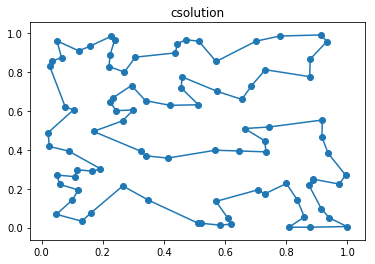

In [5]:
#tsp2.display_cpsolution()
tsp.display_c()
tsp.display_csolution()
#tsp2.psolution
#print(f"cartesian solution: {tsp2.calculate_path_length(tsp2.csolution)}\n\
#polar solution: {tsp2.calculate_path_length(tsp2.psolution)}")

render in log-polar coordinates

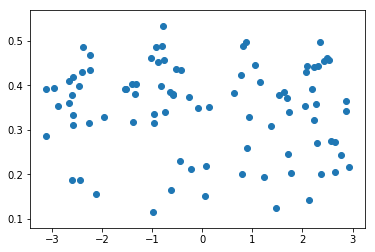

In [6]:
#tsp2.display_cpsolution()
tsp.display_p()
#tsp.display_csolution()
#tsp2.psolution
#print(f"cartesian solution: {tsp2.calculate_path_length(tsp2.csolution)}\n\
#polar solution: {tsp2.calculate_path_length(tsp2.psolution)}")

solve in polar coordinates

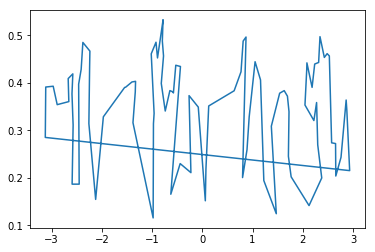

In [7]:
#tsp2.display_cpsolution()
tsp.display_psolution()
#tsp.display_csolution()
#tsp2.psolution
#print(f"cartesian solution: {tsp2.calculate_path_length(tsp2.csolution)}\n\
#polar solution: {tsp2.calculate_path_length(tsp2.psolution)}")

show polar solution in cartesian representation

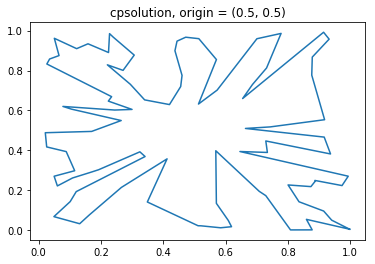

In [8]:
tsp.display_cpsolution()

solve iteratively in polar form, changing origin on each segment

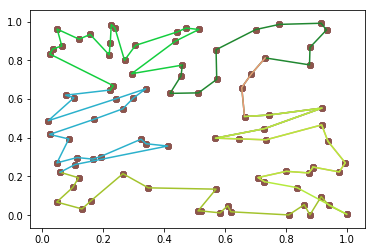

In [10]:
tsp2 = tsp
stepsize = 20
for i in range(tspsize//stepsize + 2):
#     fig = plt.figure()
    tsp2.use_subgraph(False)
    tsp2.display_c()
    tsp2.origin = (random.random(),random.random())
    tsp2.progressive_polar_solution(stepsize)
    plt.plot([tsp2.point_dict[i].x for i in tsp2.built_path[-stepsize:]], [tsp2.point_dict[i].y for i in tsp2.built_path[-stepsize:]],color=(random.random(),random.random(),random.random()))
    #print(tsp2.built_path)

calculate percent above optimal of generated solution

In [11]:
optimal = tsp2.calculate_path_length(tsp2.csolution)
built_polar = tsp2.calculate_path_length(tsp2.built_path[:90])

pao = ((built_polar - optimal)/optimal)*100

print(pao)

21.778178587473658
